<a href="https://colab.research.google.com/github/marcolinomsn/machine_learning/blob/main/Machine_Learning_%26_Analytics_(40530010055_20250_01).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Análise de Dados e Boas Práticas

**Nome:** Marcolino Matheus de Souza Nascimento

**Matrícula:** 4052025001107

**Dataset:** [Brazil Weather Information by INMET](https://www.kaggle.com/datasets/gregoryoliveira/brazil-weather-information-by-inmet)

# Definição do problema

## Hipóteses do Problema

- A maior parte da rede do INMET é composta por estações antigas e ainda ativas.
- Existe correlação entre precipitação e as demais variáveis?
- A amplitude térmica anual cresce progressivamente do Norte para o Sul do Brasil?


## Tipo de Problema

Problema de regressão supervisionada multivariada e considerando uma defasagem temporal. Dado um conjunto de variáveis meteorológicas atuais (temperatura, umidade, radiação, vento, etc.), o objetivo é prever a precipitação (chuva) em até 2 horas a frente. Esse é o conceito de previsão de curto prazo (nowcasting), amplamente utilizado em centros de monitoramento meteorológico.

A partir das leituras de uma estação meteorológica no tempo `t`, obter o acumulado de chuva no tempo `t+dt`, onde `dt = 2 horas`. Como a base de dados utilizada é do INMET tem frequência de atualização de 1 hora, o objetivo é prever a chuva com 2 leituras de antecipação.

## Seleção dos dados

O dataset escolhido para este projeto foi o histórico de dados observados do INMET. Cada linha desse dataset descreve o registro de sensores meteorológicos como temperatura, precipitação e vento, em um determinado momento (data e hora) e em um determinado local (estação meteorológica, latitude, longitude, etc).

As informações sobre a localização, são constantes (fixas) e referentes ao inventário da estação. Aplicando boas práticas de armazenamento de dados, o dataset foi dividido em um arquivo único para o inventário das estações (evitando repetição) e em 26 arquivos anuais para histórico das leituras. As colunas `ESTACAO` ou `id_station` estabelecem a relação entre a leitura e as informações da estação.

### Primeiro dataset: Inventário operacional das estações do INMET

O primeiro conjunto de dados contém informações cadastrais e operacionais das estações meteorológicas automáticas do Instituto Nacional de Meteorologia (INMET) distribuídas pelo Brasil.

### Atributos do dataset

O dataset das estações (stations.csv) contém 615 amostras. Possui os seguintes atributos:
- `region` - Região brasileira em que a estação se localiza
- `state` - Estado do brasil em que a estação se localiza
- `city_station` - Cidade em que a estação se localiza
- `id_station` - Código único de identificação da estação
- `record_first` - Data da primeira leitura da estação
- `record_last` - Data da última leitura da estação. O dataset foi confecionado para que o dia 31 de maio de 2025 seja o mais recente

### Utilização do dataset

Esse conjunto será utilizado para analisar o histórico da rede, identificar padrões temporais de instalação e desativação, além de categorizar as estações como novas ou antigas, ativas ou inativas, permitindo avaliar a estabilidade e expansão da rede ao longo do tempo.

### Segundo dataset: Histórico de dados observados das estações do INMET

O segundo conjunto de dados contém as séries temporais das variáveis meteorológicas medidas por essas estações. É um dataset bastante completo, pois trata-se de estações mteorológicas com diversos sensores e séries temporais extensas. Entre as variáveis registradas estão:

- `DATA (YYYY-MM-DD)`
- `Hora UTC`
- `PRECIPITAÇÃO TOTAL, HORÁRIO (mm)`
- `PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)`
- `PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)`
- `PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)`
- `RADIACAO GLOBAL (KJ/m²)`
- `TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)`
- `TEMPERATURA DO PONTO DE ORVALHO (°C)`
- `TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)`
- `TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)`
- `TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)`
- `TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)`
- `UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)`
- `UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)`
- `UMIDADE RELATIVA DO AR, HORARIA (%)`
- `VENTO, DIREÇÃO HORARIA (gr) (° (gr))`
- `VENTO, RAJADA MAXIMA (m/s)`
- `VENTO, VELOCIDADE HORARIA (m/s)`
- `ESTACAO`

### Utilização do dataset

 No projeto, as estações serão avaliadas quanto a sua operacionalidade, as variáveis disponibilizadas serão filtradas de acordo com a sua pertinência e dados nulos serão tratados antes de qualquer análise.

# 1 - Importação das bibliotecas necessárias

Esta seção consolida todas as importações de bibliotecas necessárias para a análise, visualização e pré-processamento dos dados.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# 2 - ...

## 2.1 - Carregamento do dataset
...

In [ ]:
# Carregamento do dataset de estações
stations = pd.read_csv("https://raw.githubusercontent.com/marcolinomsn/data_processing/refs/heads/main/dataset/stations.csv")
stations = stations.drop(columns=['lvl', 'lat', 'lon'])
print(f"Total de estações: {len(stations)}")

# Primeiras linhas
stations.head()

Total de estações: 615


,region,state,city_station,id_station,record_first,record_last
0,CO,DF,BRASILIA,A001,2000-05-07,2025-05-31
1,NE,BA,SALVADOR,A401,2000-05-13,2025-05-31
2,N,AM,MANAUS,A101,2000-05-09,2025-05-31
3,SE,RJ,ECOLOGIA AGRICOLA,A601,2000-05-07,2025-05-31
4,S,RS,PORTO ALEGRE,A801,2000-09-22,2025-05-31


## 2.2 - Criação de recursos

Inclusão de novas colunas representando características obtidas indiretamente, ou seja, por meio de cálculo. Dentro as colunas, destaca-se o period_size, que é o intervalo entre a data final e inicial de operação de uma estação. Essa feature permite uma série de conclusões posteriores a respeito da operacionalidade da rede.

In [ ]:
# Convertendo as datas em string para o formato datetime.
stations.record_first = pd.to_datetime(stations.record_first)
stations.record_last = pd.to_datetime(stations.record_last)

# Calculando o tamanho do período operacional de cada estação
stations["period_size"] = stations.record_last - stations.record_first
stations.period_size = stations.period_size.dt.days

Adicionando colunas a respeito do funcionamento da estação (ativo ou inativo) e do status de operação que indica se a estação é recente ou antiga na rede:

In [ ]:
def classify_station(row, year=2015):
    if row.record_first.year > year:
        return "New"
    else:
        return "Old"

stations['status'] = stations.apply(classify_station, axis=1)
stations['inactive'] = stations.record_last.dt.year < 2025

# Criando uma coluna combinada
stations['combined_status'] = stations.apply(
    lambda row: f"{row['status']} & {'Inactive' if row['inactive'] else 'Active'}",
    axis=1
)

### 2.2.1 - Visualização parcial do dataset

In [ ]:
stations.head()

,region,state,city_station,id_station,record_first,record_last,period_size,status,inactive,combined_status
0,CO,DF,BRASILIA,A001,2000-05-07,2025-05-31,9155,Old,False,Old & Active
1,NE,BA,SALVADOR,A401,2000-05-13,2025-05-31,9149,Old,False,Old & Active
2,N,AM,MANAUS,A101,2000-05-09,2025-05-31,9153,Old,False,Old & Active
3,SE,RJ,ECOLOGIA AGRICOLA,A601,2000-05-07,2025-05-31,9155,Old,False,Old & Active
4,S,RS,PORTO ALEGRE,A801,2000-09-22,2025-05-31,9017,Old,False,Old & Active


## 2.3 - Análise do período operacional

### 2.3.1 - Análise dos valores totais e do **espalhamento**

In [ ]:
stations.groupby('combined_status').agg({'id_station': 'count', 'period_size': 'mean'}).rename(columns={'id_station': 'stations'})

,stations,period_size
combined_status,,
New & Active,79,2759.569620
New & Inactive,48,1242.687500
Old & Active,411,6507.211679
Old & Inactive,77,5590.116883


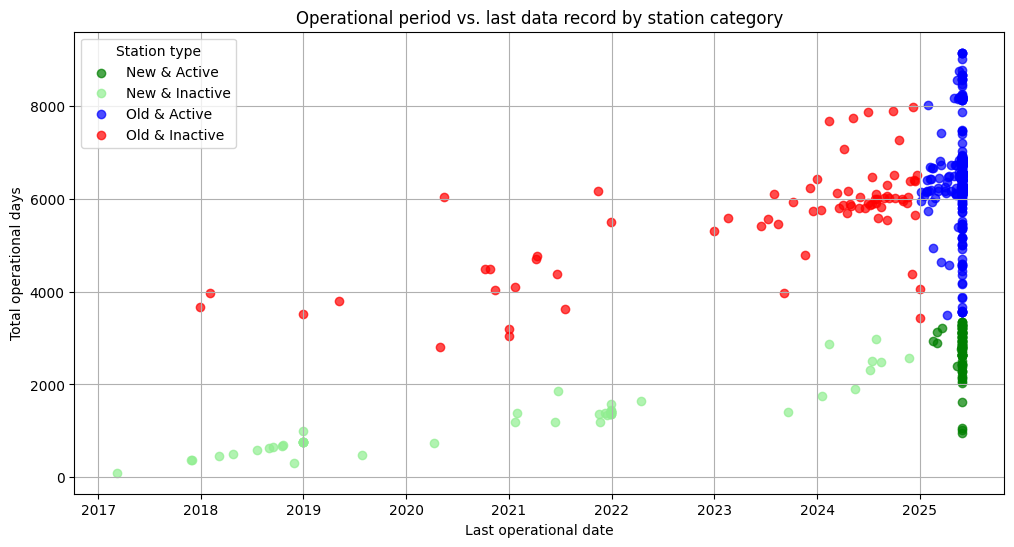

In [ ]:
colors = {
    'New & Active': 'green',
    'New & Inactive': 'lightgreen',
    'Old & Active': 'blue',
    'Old & Inactive': 'red'
}

plt.figure(figsize=(12,6))

for group, color in colors.items():
    subset = stations[stations['combined_status'] == group]
    plt.scatter(subset['record_last'], subset['period_size'],
                label=group, color=color, alpha=0.7)

plt.xlabel("Last operational date")
plt.ylabel("Total operational days")
plt.title("Operational period vs. last data record by station category")
plt.legend(title="Station type")
plt.grid(True)

Nota-se que é uma rede formada em sua maioria por estações antigas e em funcionamento, demonstrando uma sólida base de dados históricos. Além disso, existem mais estações novas ativas do que antigas e inativas. A longo prazo e mantendo essa proporção, a tendência é de que a rede se renove cada vez mais, pois o número de estações inauguradas que ainda estão funcionando é superior ao número de estações antigas que não estão mais em operação.

### 2.3.2 - Análise espacial: regional e estadual

Análise sobre a distribuição regional e estadual das estações presentes no dataset.

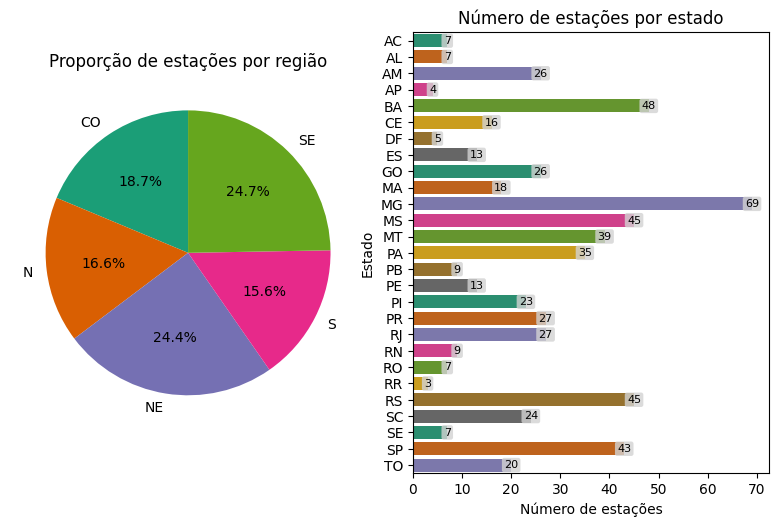

In [ ]:
# Visualizando rapidamente a distribuição de estações.
region_counts = stations.groupby('region').size()
state_counts = stations.groupby('state').size()
df_state_counts = state_counts.reset_index()
df_state_counts.columns = ['state', 'count']

# Plots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(8,5))

# Gráfico de pizza
axes[0].pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Dark2'))
axes[0].set_title('Proporção de estações por região')
plt.tight_layout()

# Gráfico de barras horizontal
sns.barplot(
    data=df_state_counts,
    x='count', y='state',
    hue='state',
    palette='Dark2',
    dodge=False,
    legend=False,
    ax=axes[1]
)

axes[1].set_title('Número de estações por estado')
axes[1].set_xlabel('Número de estações')
axes[1].set_ylabel('Estado')

# Adiciona labels nas barras
for i, v in enumerate(state_counts.values):
    axes[1].text(
    v, i, str(v),
    va='center', ha='center', fontsize=8,
    bbox=dict(facecolor='lightgray', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.2')
    )

A rede do INMET é concentrada no Sudeste e Nordeste, que abrigam, respectivamente, 24,7% e 24,4% das estações nacionais. As regiões Centro-Oeste (18,7 %), Norte (16,6 %) e Sul (15,6 %) ficam atrás.

No detalhe por estado, **Minas Gerais** lidera isolado com 69 estações, seguido do par **Rio Grande do Sul** e **Mato Grosso do Sul** (45 cada) e da **Bahia** (48). Estados amazônicos e do Nordeste como  **Roraima** (3), **Amapá** (4) e **Alagoas** (7), possuem cobertura modesta, evidenciando lacunas regionais que podem afetar a representatividade de monitoramento climático e a qualidade de serviços meteorológicos locais.

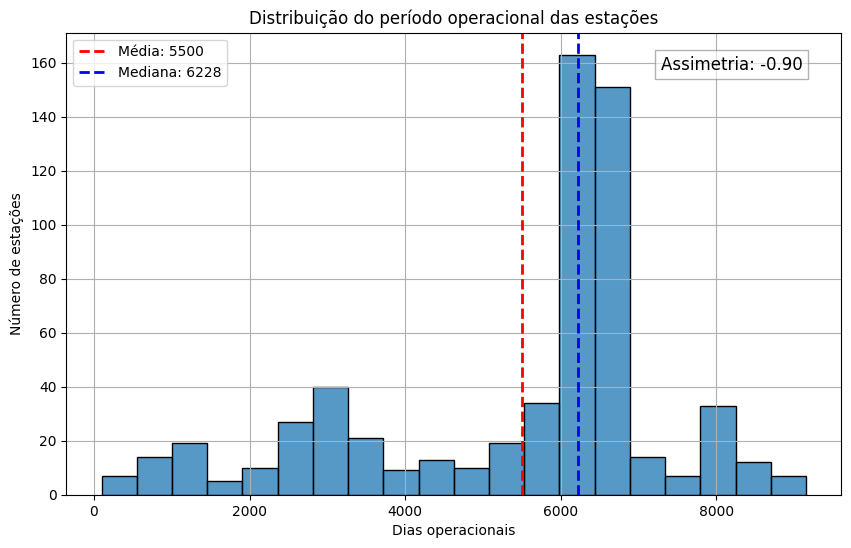

In [ ]:
# Estatísticas
median = stations.period_size.median()
mean = stations.period_size.mean()
skewness = stations.period_size.skew()

plt.figure(figsize=(10,6))
sns.histplot(
  data=stations,
  x='period_size',
  bins=20,
)

plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Média: {mean:.0f}')
plt.axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Mediana: {median:.0f}')
plt.title('Distribuição do período operacional das estações')
plt.xlabel('Dias operacionais')
plt.ylabel('Número de estações')
plt.legend()

# Mostrar skewness no gráfico
plt.text(0.95, 0.95, f'Assimetria: {skewness:.2f}',
         transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))

plt.grid(True)

O histograma do tamanho do período operacional mostra uma distribuição assimétrica à esquerda (negativa). Isso corrobora as conclusões indicadas tanto no gráfico de dispersão quanto nos números contabiliados no dataset. Há uma maior concentração de estações nos maiores períodos operacionais.

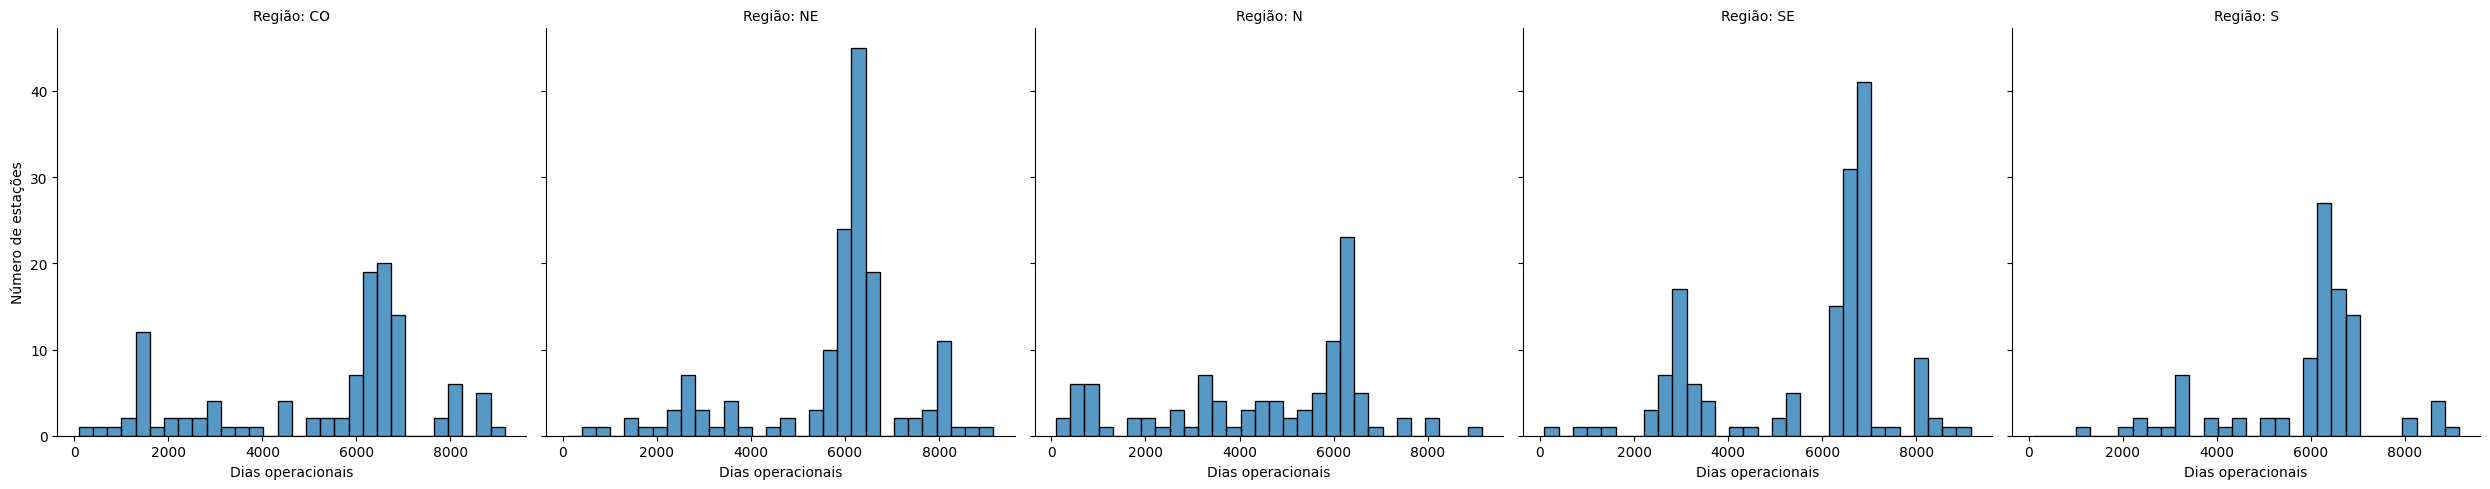

In [ ]:
# Múltiplos histogramas separados por região
histograms = sns.displot(
    data=stations,
    x="period_size",
    col="region",
    col_wrap=5,
    bins=30,
    facet_kws={'sharey': True},
)
histograms.set_titles("Região: {col_name}")
histograms.set_axis_labels("Dias operacionais", "Número de estações")

A mesma forma de distribuição é mostrada na análise regional do Brasil. Indicando um esforço em âmbito nacional de manter e renovar a rede, mesmo com diversas limitações. A diferença nos máximos das distribuições, indica que os locais com maiores quantidades de estações com períodos maiores são o Nordeste e Sudeste. Isso está fortemente relacionado à história da observação meteorológica, que expandiu das regiões costeiras e grandes centros urbanos para o interior do país. O número baixo de estações no Norte e Centro-Oeste está intimamente relacionado com a complexidade do terreno, falta de infra estrutura para as estações e baixa urbanização.

## 2.4 - Seleção de estações representativas
O dataset conta com 26 anos de dados históricos para todas as estações do Brasil. O tamanho total do dataset é de 2 GB. Para facilitar o projeto do MVP e garantir uma representatividade em todo o territórios Brasileiro, foi feito um ranking das estações com maior período operacional e o histórico utilizado no projeto conta apenas com os dados observados dessas estações.



In [ ]:
# índice da maior série em cada região
idx = stations.groupby('region')['period_size'].idxmax()

# estações com o maior período por região
stations_longest = stations.loc[idx].sort_values('region')

stations_longest

,region,state,city_station,id_station,record_first,record_last,period_size,status,inactive,combined_status
0,CO,DF,BRASILIA,A001,2000-05-07,2025-05-31,9155,Old,False,Old & Active
2,N,AM,MANAUS,A101,2000-05-09,2025-05-31,9153,Old,False,Old & Active
1,NE,BA,SALVADOR,A401,2000-05-13,2025-05-31,9149,Old,False,Old & Active
4,S,RS,PORTO ALEGRE,A801,2000-09-22,2025-05-31,9017,Old,False,Old & Active
3,SE,RJ,ECOLOGIA AGRICOLA,A601,2000-05-07,2025-05-31,9155,Old,False,Old & Active


A filtragem do dataset original foi feita localmente pelo script auxiliar:
```
filelist = glob("dataset/weather_*.csv")
idx = stations.groupby("region")["period_size"].idxmax()
stations_longest = stations.loc[idx].sort_values("region")
for filename in filelist:
    data = pd.read_csv(filename)
    data = data[data.ESTACAO.isin(stations_longest.id_station)]
    data.to_csv(filename.replace(".csv", "_filtered.csv"), index=False)
```

# 3 - Análise do histórico das estações


## 3.1 - Carregamento do dataset: Histórico de dados observados das estações
Carrega um conjunto de CSVs hospedados no github a partir do link de acesso público:
- Cada CSV é adicionado como item em uma lista.
- Ao final, a lista é concatenada para um DataFrame.

In [ ]:
URL = "https://raw.githubusercontent.com/marcolinomsn/data_processing/refs/heads/main/dataset/"

DATASET_LINKS = [
    "weather_2000_filtered.csv",
    "weather_2001_filtered.csv",
    "weather_2002_filtered.csv",
    "weather_2003_filtered.csv",
    "weather_2004_filtered.csv",
    "weather_2005_filtered.csv",
    "weather_2006_filtered.csv",
    "weather_2007_filtered.csv",
    "weather_2008_filtered.csv",
    "weather_2009_filtered.csv",
    "weather_2010_filtered.csv",
    "weather_2011_filtered.csv",
    "weather_2012_filtered.csv",
    "weather_2013_filtered.csv",
    "weather_2014_filtered.csv",
    "weather_2015_filtered.csv",
    "weather_2016_filtered.csv",
    "weather_2017_filtered.csv",
    "weather_2018_filtered.csv",
    "weather_2019_filtered.csv",
    "weather_2020_filtered.csv",
    "weather_2021_filtered.csv",
    "weather_2022_filtered.csv",
    "weather_2023_filtered.csv",
    "weather_2024_filtered.csv",
    "weather_2025_filtered.csv",
]

dataset_list = []

for link in DATASET_LINKS:
  print(f"Carregando {link}")
  dataset_list.append(pd.read_csv(URL + link))

raw_dataset = pd.concat(dataset_list)
raw_dataset = raw_dataset.reset_index(drop=True)

Carregando weather_2000_filtered.csv
Carregando weather_2001_filtered.csv
Carregando weather_2002_filtered.csv
Carregando weather_2003_filtered.csv
Carregando weather_2004_filtered.csv
Carregando weather_2005_filtered.csv
Carregando weather_2006_filtered.csv
Carregando weather_2007_filtered.csv
Carregando weather_2008_filtered.csv
Carregando weather_2009_filtered.csv
Carregando weather_2010_filtered.csv
Carregando weather_2011_filtered.csv
Carregando weather_2012_filtered.csv
Carregando weather_2013_filtered.csv
Carregando weather_2014_filtered.csv
Carregando weather_2015_filtered.csv
Carregando weather_2016_filtered.csv
Carregando weather_2017_filtered.csv
Carregando weather_2018_filtered.csv
Carregando weather_2019_filtered.csv
Carregando weather_2020_filtered.csv
Carregando weather_2021_filtered.csv
Carregando weather_2022_filtered.csv
Carregando weather_2023_filtered.csv
Carregando weather_2024_filtered.csv
Carregando weather_2025_filtered.csv


## 3.2 - Formatação do dataset

### 3.2.1 - Remoção de colunas redundantes e renomeação de colunas
- Renomear colunas para o padrão inglês e snake_case. Objetivo é organizar o código, encurtar os nomes das colunas e melhorar a leitura.
- Remoção de colunas reduntantes. Por exemplo, temperatura do ar máxima na hora e mínima podem ser representadas pela temperatura do ar instantânea, que é a média na hora.

In [ ]:
COLUMNS_TO_RENAME = {
  "ESTACAO": "station_code",
  "DATA (YYYY-MM-DD)": "date",
  "Hora UTC": "time",
  "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)": "temperature",
  "TEMPERATURA DO PONTO DE ORVALHO (°C)": "dew_point",
  "VENTO, VELOCIDADE HORARIA (m/s)": "wind_speed",
  "VENTO, DIREÇÃO HORARIA (gr) (° (gr))": "wind_direction",
  "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)": "precipitation",
  "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)": "pressure",
  "UMIDADE RELATIVA DO AR, HORARIA (%)": "relative_humidity",
  "VENTO, RAJADA MAXIMA (m/s)": "wind_gust",
  "RADIACAO GLOBAL (KJ/m²)": "radiation",
}

dataset = raw_dataset[[k for k in COLUMNS_TO_RENAME if k in raw_dataset.columns]]
dataset = dataset.rename(columns=COLUMNS_TO_RENAME)

### 3.2.2 - Formatando Radiação Solar

Substituição de radiação solar nula para 0, pois o valor NaN está associado a passagem de nebulosidade ou período noturno. É uma informação que não pode ser filtrada quando os dados nulos forem removidos.

In [ ]:
dataset.radiation = dataset.radiation.replace(np.nan, 0)

### 3.2.3 - Formatação do datetime para ser utilizado como indice do dataset
- O dataset original fornece a data separada da hora e com formatação diferente em períodos distintos. No início o formato da hora é HH:MM e após uma determinada data, houve uma modificação para HHMM UTC.
- O datetime foi definido como indice do dataset para facilitar manipulações futuras.

In [ ]:
dataset["datetime"] = dataset.date + dataset.time
dataset.datetime = dataset.datetime.str.replace("00 UTC", ":00")
dataset.datetime = pd.to_datetime(dataset.datetime, format="%Y-%m-%d%H:%M")
dataset = dataset.drop(columns=['date', 'time'])
dataset.set_index("datetime", inplace=True)
dataset = dataset.sort_index()

### 3.2.4 - União dos datasets de inventário com histórico de dados

In [ ]:
dataset = dataset.join(
    stations_longest.set_index('id_station'),
    on='station_code',
    how='left'
)

### 3.2.5 - Visualiazação parcial do dataset

In [ ]:
dataset.head()

,station_code,temperature,dew_point,wind_speed,wind_direction,precipitation,pressure,relative_humidity,wind_gust,radiation,region,state,city_station,record_first,record_last,period_size,status,inactive,combined_status
datetime,,,,,,,,,,,,,,,,,,,
2000-05-07 00:00:00,A001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,CO,DF,BRASILIA,2000-05-07,2025-05-31,9155,Old,False,Old & Active
2000-05-07 00:00:00,A601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,SE,RJ,ECOLOGIA AGRICOLA,2000-05-07,2025-05-31,9155,Old,False,Old & Active
2000-05-07 01:00:00,A601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,SE,RJ,ECOLOGIA AGRICOLA,2000-05-07,2025-05-31,9155,Old,False,Old & Active
2000-05-07 01:00:00,A001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,CO,DF,BRASILIA,2000-05-07,2025-05-31,9155,Old,False,Old & Active
2000-05-07 02:00:00,A001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,CO,DF,BRASILIA,2000-05-07,2025-05-31,9155,Old,False,Old & Active


## 3.3 - Tratamento de Valores Nulos

In [ ]:
# Verificar a presença de valores nulos no dataset
print("Valores nulos no dataset:")
dataset.isna().sum()

Valores nulos no dataset:


,0
station_code,0
temperature,78876
dew_point,82760
wind_speed,100378
wind_direction,107031
precipitation,85269
pressure,82748
relative_humidity,82614
wind_gust,102381
radiation,0


O dataset já foi tratado para remoção de valores NaN. Para verificar se o tratamento está correto e não há valores nulos no dataset, foi apresentada a soma de valores nulos para cada coluna.

Aproveitamento de ~88.7% dos dados totais após limpeza de NaN.

In [ ]:
# Tamanho original do dataset.
original_len = len(dataset)

# Remove NaNs e reconta.
valid_dataset = dataset.dropna()

# Tamanho do dataset após a filtragem de dados nulos.
valid_len = len(valid_dataset)
percent = (valid_len / original_len) * 100
print(f"Antes da remoção haviam {original_len} leituras.\nApós remoção de NaNs: {valid_len} instâncias ({percent:.1f}%).")

# Verificar a presença de valores nulos no dataset
print("Valores nulos no dataset:")
valid_dataset.isna().sum()

Antes da remoção haviam 1095216 leituras.
Após remoção de NaNs: 971203 instâncias (88.7%).
Valores nulos no dataset:


,0
station_code,0
temperature,0
dew_point,0
wind_speed,0
wind_direction,0
precipitation,0
pressure,0
relative_humidity,0
wind_gust,0
radiation,0


## 3.4 - Climatologias das 5 estações representativas

In [ ]:
# Função que plota o mapa de calor. Essa visualização é muito prática para situações com mais de 2 eixos e/ou que existam visualizações secundárias.
# Na climatologia é possível exibir em um eixo a localização, em outro eixo o período temporal e como coloração os valores.

def heatmap_plot(valid_dataset, variable, variable_unit, title):
    df = valid_dataset.copy()
    # Extrai mês e nome do mês a partir do índice datetime
    df['month'] = df.index.month
    df['month_name'] = df.index.strftime('%b')
    df['station_label'] = (
        df['city_station'] + ' (' + df['station_code'] + ') - ' + df['region']
    )

    monthly_climatology = df.assign(year=df.index.year, month=df.index.month).groupby(['station_label', 'year', 'month_name'])[variable]

    if variable == "precipitation":
        climatology = monthly_climatology.sum().reset_index()
    else:
        climatology = monthly_climatology.mean().reset_index()

    climatology = climatology.groupby(['station_label', 'month_name'])[variable].mean().unstack()
    climatology = climatology[list(calendar.month_abbr)[1:]]

    plt.figure(figsize=(12, 3))
    sns.heatmap(
        climatology,
        cmap='coolwarm',
        annot=True, fmt='.1f',
        linewidths=.4,
        cbar_kws={'label': variable_unit}
    )
    plt.title(f'Climatologia Mensal – {title}')
    plt.xlabel('Mês')
    plt.ylabel('Estação')
    plt.show()

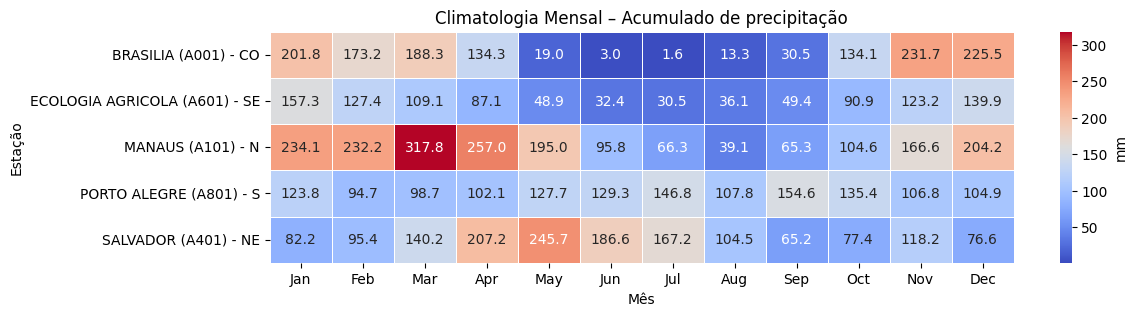

In [ ]:
heatmap_plot(valid_dataset, "precipitation", "mm", "Acumulado de precipitação")

**Manaus (N):** muito úmido o ano todo, pico em março (~ 320 mm) e “mínimo” ainda elevado em julho (~ 65 mm). **Brasília (CO):** estação chuvosa robusta no verão (>200 mm nov–mar) e estiagem quase nula em jun–jul. **Ecologia Agrícola (SE):** verão chuvoso (110–160 mm) e seca moderada em jun–ago (30–50 mm). **Salvador (NE):** regime bimodal, máximos em abr–mai e jun–jul, verão mais seco. **Porto Alegre (S):** chuva relativamente uniforme o ano todo (~95–155 mm).

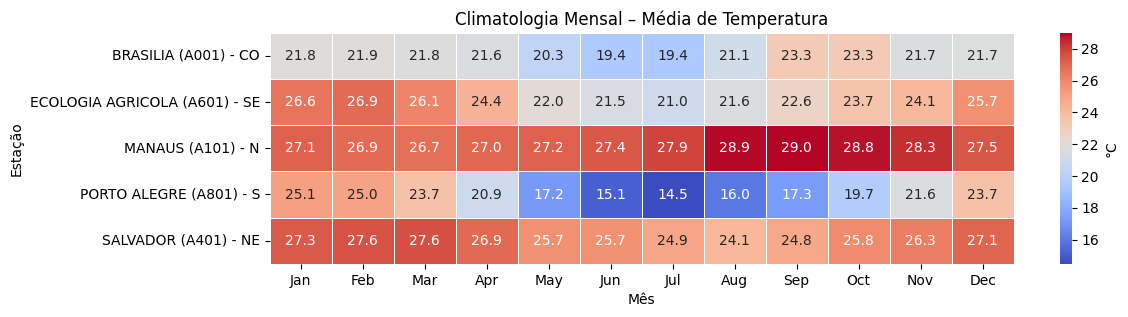

In [ ]:
heatmap_plot(valid_dataset, "temperature", "°C", "Média de Temperatura")

Temperatura média reflete três regimes: (1) **Equatorial – Manaus** fica quase estável (27–29 °C) o ano todo; (2) **Tropical – Salvador e Ecologia Agrícola** mantêm-se quentes, mas caem 2-4 °C no inverno, enquanto Brasília esfria mais (-3 °C) entre maio-agosto; (3) **Subtropical – Porto Alegre** apresenta a maior amplitude, indo de ~25 °C no verão a 14–16 °C em junho-agosto. Em síntese, a sazonalidade térmica cresce de Norte para Sul e de áreas costeiras/oceânicas para o interior.

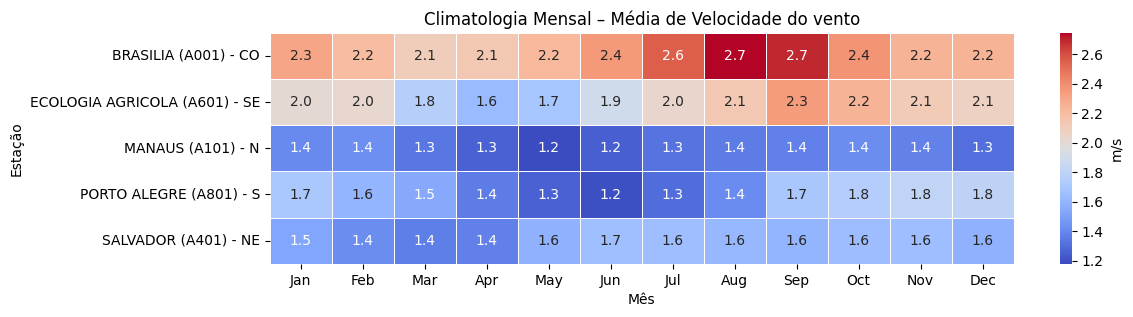

In [ ]:
heatmap_plot(valid_dataset, "wind_speed", "m/s", "Média de Velocidade do vento")

**Brasília** alcança os maiores valores médios e um pico de ~ 2,7 m/s em agosto - setembro, típico do período seco do Planalto quando o gradiente de pressão se intensifica. **Ecologia Agrícola (Sudeste)** mantém regime intermediário (1,6 - 2,3 m/s) com leve reforço na primavera, enquanto **Porto Alegre** sobe de ~ 1,2 m/s no inverno para ~ 1,8 m/s na primavera, refletindo a passagem mais frequente de frentes. **Salvador** apresenta ventos relativamente constantes perto de 1,6 m/s durante todo o ano, e **Manaus** exibe as menores velocidades (~ 1,2 - 1,4 m/s) com variação mínima, condizente com a densa cobertura amazônica e fraca sazonalidade dinâmica.

## 3.5 - Matriz de Correlação

A matriz de correlação mede a força e a direção de uma relação linear que os atributos numéricos das espécies podem ter. Valores próximos a 1 indicam uma forte correlação positiva, -1 uma forte correlação negativa, e 0 ausência de correlação linear.

/tmp/ipython-input-182-82381130.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


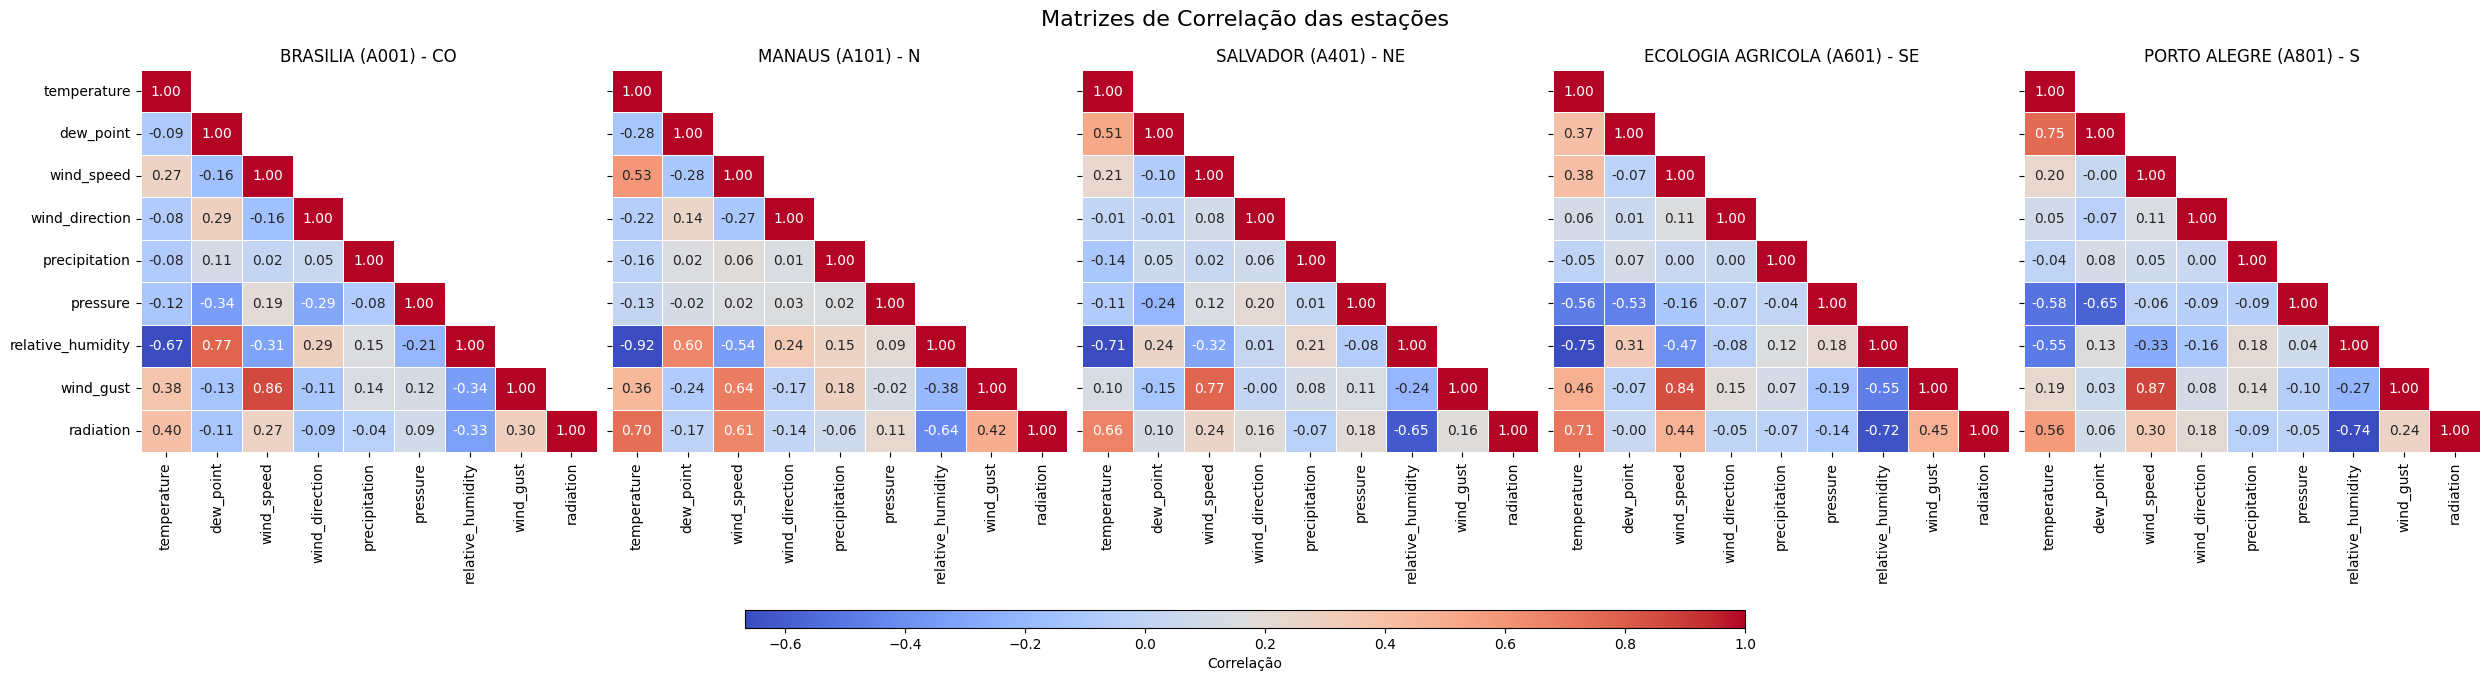

In [ ]:
# Matrizes de correlação
data_columns = ['station_code', 'temperature', 'dew_point', 'wind_speed', 'wind_direction', 'precipitation', 'pressure', 'relative_humidity', 'wind_gust', 'radiation']
groups = valid_dataset[data_columns].groupby('station_code')

fig, axes = plt.subplots(1, 5, figsize=(25, 6), sharey=True)
fig.suptitle('Matrizes de Correlação das estações', fontsize=16, y=0.98)

for ax, (code, df) in zip(axes, groups):
    station = stations_longest[stations_longest.id_station == code].iloc[0]
    corr = df.drop(columns='station_code').corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    hm = sns.heatmap(
        corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f',
        linewidths=.5, cbar=False, ax=ax
    )
    ax.set_title(f'{station.city_station} ({code}) - {station.region}')

cbar_ax = fig.add_axes([0.30, -0.05, 0.40, 0.03])

fig.colorbar(
    axes[0].collections[0],
    cax=cbar_ax,
    orientation='horizontal',
    label='Correlação'
)

fig.tight_layout()

plt.show()

Em todas as estações, três correlações dominam: `temperatura` × `umidade relativa` (~ −0.60), `temperatura` × `radiação` (0.40 – 0.71) e `rajada` × `vento médio` (0.83 – 0.87); já `precipitação` mantém ρ≈0 com as demais variáveis, confirmando sua natureza episódica.

- **Manaus** exibe `temperatura` e `ponto de orvalho` praticamente colados (ρ = 0.92), sinal de ar saturado;
- **Brasília** reflete a estação seca, com `radiação alta` e `temperatura` elevada (ρ = 0.40) mas `ponto de orvalho` dissociado (ρ ≈ 0), enquanto `radiação` e umidade se opõem fortemente (ρ = −0.72);

- **Salvador** mantém correlação `radiação`–`temperatura` de 0.66, limitada por umidade (ρ = −0.71);

- No Sudeste, **Ecologia Agrícola** repete o padrão centro-oeste porém com seca mais branda e `rajadas` muito ligadas ao `vento` (ρ = 0.84);

- **Porto Alegre** destaca-se pela anticorrelação `temperatura–pressão` mais forte do grupo (ρ = −0.65), típica da passagem de frentes frias.

# 4 - Pré-Processamento de dados para previsão

O pré-processamento é essencial para colocar os dados no formato adequado e otimizado, permitindo que o algoritmo opere com máximo desempenho.

## 4.1 - Criação de recursos para previsão

Adicionando coluna de amplitude térmica. Esse aspecto pode contribuir para a previsão, pois amplitudes grandes podem estar relacionadas a passagem de frente-fria ou a aquecimento diurno acentuado. Ambos os fenômenos podem resultar em precipitação.

In [ ]:
def plus_2h(s):
    shifted = s.reindex(s.index + pd.Timedelta(hours=2))
    shifted.index = s.index
    return shifted


def rolling_amp(s):
    return (
        s.sort_index()
         .rolling("24h", min_periods=12)
         .apply(lambda x: x.max() - x.min(), raw=True)
    )


valid_dataset = (
    valid_dataset.sort_index()
      .groupby("station_code", group_keys=False)
      .apply(
          lambda g: g.assign(
              thermal_amplitude_24h = rolling_amp(g["temperature"]),
              precip_plus2h         = plus_2h(g["precipitation"])
          ),
      )
      .dropna(subset=["thermal_amplitude_24h", "precip_plus2h"])
)
valid_dataset.tail()

,station_code,temperature,dew_point,wind_speed,wind_direction,precipitation,pressure,relative_humidity,wind_gust,radiation,...,state,city_station,record_first,record_last,period_size,status,inactive,combined_status,thermal_amplitude_24h,precip_plus2h
datetime,,,,,,,,,,,,,,,,,,,,,
2025-05-31 20:00:00,A601,21.1,16.2,1.1,210.0,0.0,1015.6,73.0,6.6,176.2,...,RJ,ECOLOGIA AGRICOLA,2000-05-07,2025-05-31,9155,Old,False,Old & Active,7.4,0.0
2025-05-31 21:00:00,A001,21.9,15.1,1.1,129.0,0.0,889.7,65.0,3.2,92.8,...,DF,BRASILIA,2000-05-07,2025-05-31,9155,Old,False,Old & Active,10.2,0.0
2025-05-31 21:00:00,A101,27.7,23.0,0.8,221.0,0.0,1005.5,76.0,3.2,321.4,...,AM,MANAUS,2000-05-09,2025-05-31,9153,Old,False,Old & Active,4.8,0.0
2025-05-31 21:00:00,A401,24.5,22.2,1.6,186.0,0.0,1011.2,87.0,6.0,2.5,...,BA,SALVADOR,2000-05-13,2025-05-31,9149,Old,False,Old & Active,5.2,0.0
2025-05-31 21:00:00,A601,20.3,17.2,1.0,212.0,0.0,1016.1,82.0,4.9,8.1,...,RJ,ECOLOGIA AGRICOLA,2000-05-07,2025-05-31,9155,Old,False,Old & Active,7.4,0.0


## 4.2 - Amostragem
Divisão do conjunto em treinamento e teste.

In [ ]:
# Dividir os dados em conjuntos de treino e teste
data_columns = ["station_code", "temperature", "dew_point", "wind_speed", "wind_direction", "precipitation", "pressure", "relative_humidity", "wind_gust", "radiation", "thermal_amplitude_24h", "precip_plus2h"]
valid_dataset = valid_dataset[data_columns]

X = valid_dataset.drop(columns=["station_code", "precip_plus2h"])
y = valid_dataset.precip_plus2h
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [ ]:
print(f"Dimensões de X_train: {X_train.shape}")
print(f"Dimensões de X_test: {X_test.shape}")
print(f"Dimensões de y_train: {y_train.shape}")
print(f"Dimensões de y_test: {y_test.shape}")

Dimensões de X_train: (669608, 10)
Dimensões de X_test: (286975, 10)
Dimensões de y_train: (669608,)
Dimensões de y_test: (286975,)


## 4.3 - Normalização

A normalização escala os dados para um intervalo fixo, geralmente entre 0 e 1. É útil quando o algoritmo de machine learning assume que as características estão em uma escala semelhante.



In [ ]:
# Inicializar o MinMaxScaler
scaler_norm = MinMaxScaler()

In [ ]:
# Aprende min e max APENAS de X_train
scaler_norm.fit(X_train)
X_train_normalized = scaler_norm.transform(X_train)
# Usa a média e o desvio padrão aprendidos de X_train
X_test_normalized = scaler_norm.transform(X_test)

In [ ]:
# Exibir as primeiras linhas dos dados normalizados (como DataFrame para melhor visualização)
df_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)

In [ ]:
print("\nPrimeiras 5 linhas dos dados normalizados (treino):")
df_normalized.head()


Primeiras 5 linhas dos dados normalizados (treino):


,temperature,dew_point,wind_speed,wind_direction,precipitation,pressure,relative_humidity,wind_gust,radiation,thermal_amplitude_24h
0,0.373576,0.399606,0.368794,0.320334,0.0,0.757804,0.755556,0.131098,0.000146,0.333333
1,0.523918,0.561024,0.127660,0.373259,0.0,0.778256,0.855556,0.079268,0.000000,0.517544
2,0.722096,0.517717,0.134752,0.331476,0.0,0.748116,0.400000,0.050813,0.006329,0.416667
3,0.448747,0.397638,0.262411,0.314763,0.0,0.135091,0.600000,0.071138,0.000000,0.407895
4,0.451025,0.442913,0.092199,0.426184,0.0,0.790635,0.700000,0.066057,0.029298,0.307018


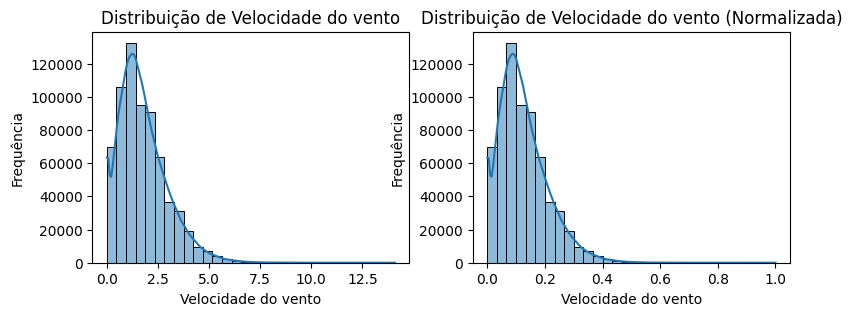

In [ ]:
# Visualização da distribuição após a normalização (exemplo para uma característica)
fig, axes = plt.subplots(1, 2, figsize=(9,3))
sns.histplot(X_train['wind_speed'], kde=True, bins=30, ax=axes[0])
axes[0].set_title('Distribuição de Velocidade do vento')
axes[0].set_xlabel('Velocidade do vento')
axes[0].set_ylabel('Frequência')

sns.histplot(df_normalized['wind_speed'], kde=True, bins=30, ax=axes[1])
axes[1].set_title('Distribuição de Velocidade do vento (Normalizada)')
axes[1].set_xlabel('Velocidade do vento')
axes[1].set_ylabel('Frequência')

plt.show()

O histograma de *wind_speed* após a normalização mostra redução na escala da velocidade do vento para o intervalo 0-1, mas manteve a forte assimetria positiva refletida no acúmulo de valores baixos e na longa cauda de rajadas intensas.

## 4.4 - Padronização

A padronização (ou Z-score scaling) transforma os dados para ter média 0 e desvio padrão 1. É útil para algoritmos que são sensíveis à escala das características, como SVMs ou redes neurais.

In [ ]:
# Inicializar o StandardScaler
scaler_std = StandardScaler()

In [ ]:
# Aprende média e desvio padrão APENAS de X_train
scaler_std.fit(X_train)
X_train_standardized = scaler_std.transform(X_train)
# Usa a média e o desvio padrão aprendidos de X_train
X_test_standardized = scaler_std.transform(X_test)

In [ ]:
# Exibir as primeiras linhas dos dados padronizados (como DataFrame para melhor visualização)
df_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns)

In [ ]:
print("\nPrimeiras 5 linhas dos dados padronizados (treino):")
df_standardized.head()


Primeiras 5 linhas dos dados padronizados (treino):


,temperature,dew_point,wind_speed,wind_direction,precipitation,pressure,relative_humidity,wind_gust,radiation,thermal_amplitude_24h
0,-1.222103,-0.920703,2.914347,-0.357240,-0.131671,0.438440,0.231215,3.224835,-0.548374,-0.115438
1,0.102542,0.768132,0.031192,-0.163784,-0.131671,0.513431,0.760517,1.202457,-0.553245,1.250329
2,1.848666,0.315030,0.115990,-0.316512,-0.131671,0.402918,-1.650747,0.092131,-0.341456,0.502409
3,-0.559781,-0.941299,1.642367,-0.377603,-0.131671,-1.844827,-0.592143,0.885221,-0.553245,0.437372
4,-0.539710,-0.467601,-0.392802,0.029672,-0.131671,0.558820,-0.062841,0.686948,0.427086,-0.310548


<Figure size 800x600 with 0 Axes>

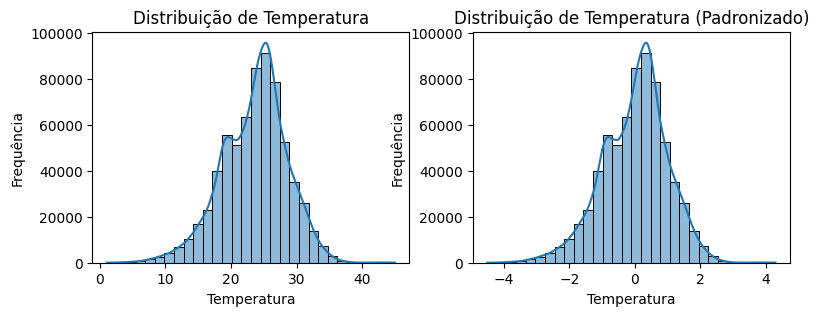

In [ ]:
# Visualização da distribuição após a padronização
plt.figure(figsize=(8, 6))

fig, axes = plt.subplots(1, 2, figsize=(9,3))
sns.histplot(X_train['temperature'], kde=True, bins=30, ax=axes[0])
axes[0].set_title('Distribuição de Temperatura')
axes[0].set_xlabel('Temperatura')
axes[0].set_ylabel('Frequência')

sns.histplot(df_standardized['temperature'], kde=True, bins=30, ax=axes[1])
axes[1].set_title('Distribuição de Temperatura (Padronizado)')
axes[1].set_xlabel('Temperatura')
axes[1].set_ylabel('Frequência')

plt.show()

O histograma de *temperature* após a padronização mostra deslocamento da média para 0 e desvio padrão em 1, mantendo a mesma forma da distribuição, inclusive a assimetria positiva e a cauda longa à direita.

# 5 - Conclusão

As três hipóteses levantadas foram validadas:

1.   *A maior parte da rede do INMET é composta por estações antigas e ainda ativas?*

Sim, a rede nacional de estações do INMET é predominantemente composta por estações instaladas antes de 2015 e que continuam operando até hoje. Ao mesmo tempo, a presença significativa de estações novas e ativas indica esforços contínuos de expansão e modernização.

2.   *Existe correlação entre precipitação e as demais variáveis medidas*

A climatologia indica que não há correlação linear relevante entre precipitação e as demais variáveis: em todos os cinco heatmaps, os coeficientes “precipitação × temperatura”, “precipitação × umidade”, “precipitação × radiação”, “precipitação × vento” e “precipitação × pressão” oscilam perto de 0 (-0,15 ≤ ρ ≤ 0,15). Isso confirma que a chuva diária é um fenômeno episódico.

3.   *A amplitude térmica anual cresce progressivamente do Norte para o Sul do Brasil?*

Sim. O conjunto mostra variação de ~2 °C em Manaus contra ~11 °C em Porto Alegre, confirmando aumento latitudinal da sazonalidade térmica.